In [3]:
#enabling arrow just for a backup if pandas is needed at any point of time
import numpy as np
import pandas as pd
from datetime import datetime


from pyspark.sql import SparkSession
data_directory_path = 'C:/Users/saidh/Downloads/Market Basket Analysis/'

aisles = pd.read_csv(data_directory_path + 'aisles.csv')
aisles = reduce_mem_usage(aisles)
departments = pd.read_csv(data_directory_path + 'departments.csv')
departments = reduce_mem_usage(departments)
order_products_prior = pd.read_csv(data_directory_path + 'order_products__prior.csv')
order_products_prior = reduce_mem_usage(order_products_prior)

order_products_train = pd.read_csv(data_directory_path + 'order_products__train.csv')
order_products_train = reduce_mem_usage(order_products_train)
orders = pd.read_csv(data_directory_path + 'orders.csv')
# Replacing numbers with their corresponding hour representation 

products = pd.read_csv(data_directory_path + 'products.csv') 

order_products = pd.concat([order_products_train, order_products_prior])
order_products = order_products.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

df=order_products
df = df[df['eval_set'] == 'train']
df

product_counts = df.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop=True)
product_counts 

freq_products = list(product_counts.product_id)
del product_counts 
freq_products[1:10]

order_products = df[df.product_id.isin(freq_products)]
del df
order_products.shape
print(order_products)

df=order_products[['order_id','product_name','reordered']].set_index('order_id')
df

basket = df.pivot_table(columns='product_name', values='reordered', index='order_id').reset_index().fillna(0).set_index('order_id')
basket


def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket = basket.applymap(encode_units)
basket.head()




shortbasket = basket[:100000]
shortbasket



Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -159.9%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -92.7%
Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
          order_id  product_id  add_to_cart_order  reordered  \
1828410          1       22035                  8          1   
1828429       2445       22035                  4          0   
1828430       2445       33731                  7          0   
1828431       2445       40604                 20          1   
1828440       2937       40604                 16          1   
...            ...         ...                ...        ...   
29573237   3415183        5077                 11          1   
29573248   3417341        5077                  3          1   
29573251   3417

product_name,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,...,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420998,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3421049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3421056,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [53]:
shortbasket=basket[0:100000]

In [2]:
''' 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
'''
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

In [4]:
import time
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import matplotlib.pyplot as plt

In [58]:
def perform_rule_calculation(transact_items_matrix, rule_type="fpgrowth", min_support=0.001):
    """
    desc: this function performs the association rule calculation 
    @params:
        - transact_items_matrix: the transaction X Items matrix
        - rule_type: 
                    - apriori or Growth algorithms (default="fpgrowth")
                    
        - min_support: minimum support threshold value (default = 0.001)
        
    @returns:
        - the matrix containing 3 columns:
            - support: support values for each combination of items
            - itemsets: the combination of items
            - number_of_items: the number of items in each combination of items
            
        - the excution time for the corresponding algorithm
        
    """
    start_time = 0
    total_execution = 0
    
    if(not rule_type=="fpgrowth"):
        start_time = time.time()
        rule_items = apriori(transact_items_matrix, 
                       min_support=0.0001, 
                       use_colnames=True,low_memory=True)
        total_execution = time.time() - start_time
        print("Computed Apriori!")
        
    else:
        start_time = time.time()
        rule_items = fpgrowth(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Fp Growth!")
    
    rule_items['number_of_items'] = rule_items['itemsets'].apply(lambda x: len(x))
    
    return rule_items, total_execution

In [30]:
def compute_association_rule(rule_matrix, metric="lift", min_thresh=1):
    """
    @desc: Compute the final association rule
    @params:
        - rule_matrix: the corresponding algorithms matrix
        - metric: the metric to be used (default is lift)
        - min_thresh: the minimum threshold (default is 1)
        
    @returns:
        - rules: all the information for each transaction satisfying the given metric & threshold
    """
    rules = association_rules(rule_matrix, 
                              metric=metric, 
                              min_threshold=min_thresh)
    
    return rules

In [31]:
# Plot Lift Vs Coverage(confidence) 
def plot_metrics_relationship(rule_matrix, col1, col2):
    """
    desc: shows the relationship between the two input columns 
    @params:
        - rule_matrix: the matrix containing the result of a rule (apriori or Fp Growth)
        - col1: first column
        - col2: second column
    """
    fit = np.polyfit(rule_matrix[col1], rule_matrix[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rule_matrix[col1], rule_matrix[col2], 'yo', rule_matrix[col1], 
    fit_funt(rule_matrix[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

In [32]:
def compare_time_exec(algo1=list, alg2=list):
    """
    @desc: shows the execution time between two algorithms
    @params:
        - algo1: list containing the description of first algorithm, where
            
        - algo2: list containing the description of second algorithm, where
    """
    
    execution_times = [algo1[1], algo2[1]]
    algo_names = (algo1[0], algo2[0])
    y=np.arange(len(algo_names))
    
    plt.bar(y,execution_times,color=['orange', 'blue'])
    plt.xticks(y,algo_names)
    plt.xlabel('Algorithms')
    plt.ylabel('Time')
    plt.title("Execution Time (seconds) Comparison")
    plt.show()

In [56]:
shortbasket=reduce_mem_usage(shortbasket)

Memory usage of dataframe is 72.32 MB
Memory usage after optimization is: 9.67 MB
Decreased by 86.6%


In [57]:
fpgrowth_matrix, fp_growth_exec_time = perform_rule_calculation(shortbasket) # Run the algorithm
print("Fp Growth execution took: {} seconds".format(fp_growth_exec_time))


C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Computed Fp Growth!
Fp Growth execution took: 4.155130624771118 seconds


In [52]:
fpgrowth_matrix.head()

,support,itemsets,number_of_items
0,0.016676,(Organic Whole String Cheese),1
1,0.026180,(Asparagus),1
2,0.019542,(Spring Water),1
3,0.017890,(Organic Garnet Sweet Potato (Yam)),1
4,0.022067,(Organic Baby Arugula),1


In [35]:
fpgrowth_matrix.tail()

,support,itemsets,number_of_items
1570,0.002706,"(Lime Sparkling Water, Sparkling Lemon Water)",2
1571,0.001470,"(Bag of Organic Bananas, Sparkling Lemon Water)",2
1572,0.001279,"(Lime Sparkling Water, Sparkling Water Grapefr...",3
1573,0.001833,"(Green Onions, Banana)",2
1574,0.001087,"(Green Onions, Large Lemon)",2


In [36]:
fp_growth_rule_lift = compute_association_rule(fpgrowth_matrix)

In [37]:
fp_growth_rule_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Organic Whole String Cheese),(Bag of Organic Bananas),0.016676,0.142376,0.004891,0.293291,2.059971,0.002517,1.213546
1,(Bag of Organic Bananas),(Organic Whole String Cheese),0.142376,0.016676,0.004891,0.034351,2.059971,0.002517,1.018304
2,(Organic Whole String Cheese),(Organic Raspberries),0.016676,0.045594,0.002227,0.133546,2.929031,0.001467,1.101508
3,(Organic Raspberries),(Organic Whole String Cheese),0.045594,0.016676,0.002227,0.048843,2.929031,0.001467,1.033819
4,(Organic Whole String Cheese),(Organic Baby Spinach),0.016676,0.085828,0.002206,0.132268,1.541078,0.000774,1.053519


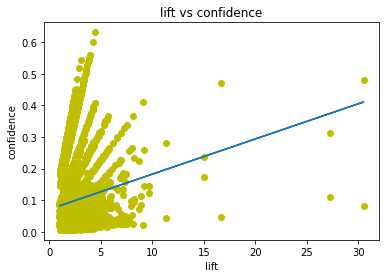

In [38]:
plot_metrics_relationship(fp_growth_rule_lift, col1='lift', col2='confidence')

In [39]:
fp_growth_rule = compute_association_rule(fpgrowth_matrix, metric="confidence", min_thresh=0.2)
fp_growth_rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Organic Whole String Cheese),(Bag of Organic Bananas),0.016676,0.142376,0.004891,0.293291,2.059971,0.002517,1.213546
1,(Organic Whole String Cheese),(Organic Strawberries),0.016676,0.091668,0.003964,0.237700,2.593062,0.002435,1.191568
2,(Organic Whole String Cheese),(Banana),0.016676,0.176420,0.003836,0.230032,1.303889,0.000894,1.069629
3,"(Organic Whole String Cheese, Organic Raspberr...",(Bag of Organic Bananas),0.002227,0.142376,0.001034,0.464115,3.259780,0.000716,1.600387
4,"(Organic Whole String Cheese, Bag of Organic B...",(Organic Raspberries),0.004891,0.045594,0.001034,0.211329,4.635014,0.000811,1.210145


In [16]:
shortbasket=reduce_mem_usage(shortbasket)

Memory usage of dataframe is 72.32 MB
Memory usage after optimization is: 9.67 MB
Decreased by 86.6%


In [59]:
apriori_matrix, apriori_exec_time = perform_rule_calculation(shortbasket, rule_type="apriori")
print("Apriori Execution took: {} seconds".format(apriori_exec_time))

C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Computed Apriori!
Apriori Execution took: 24.70202112197876 seconds


In [43]:
apriori_matrix.head()

,support,itemsets,number_of_items
0,0.018668,(100% Whole Wheat Bread),1
1,0.013298,(2% Reduced Fat Milk),1
2,0.017304,(Apple Honeycrisp Organic),1
3,0.026180,(Asparagus),1
4,0.142376,(Bag of Organic Bananas),1


In [44]:
apriori_matrix.tail()

,support,itemsets,number_of_items
1570,0.001289,"(Organic Raspberries, Organic Whole Milk, Orga...",3
1571,0.001002,"(Organic Raspberries, Organic Strawberries, Or...",3
1572,0.001385,"(Organic Hass Avocado, Bag of Organic Bananas,...",4
1573,0.001087,"(Organic Hass Avocado, Organic Cucumber, Bag o...",4
1574,0.001811,"(Organic Hass Avocado, Organic Raspberries, Ba...",4


In [45]:
apriori_rule_lift = compute_association_rule(apriori_matrix)

In [46]:
apriori_rule_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Bag of Organic Bananas),(100% Whole Wheat Bread),0.142376,0.018668,0.002802,0.019683,1.054349,0.000144,1.001035
1,(100% Whole Wheat Bread),(Bag of Organic Bananas),0.018668,0.142376,0.002802,0.150114,1.054349,0.000144,1.009105
2,(Banana),(100% Whole Wheat Bread),0.176420,0.018668,0.004869,0.027602,1.478546,0.001576,1.009187
3,(100% Whole Wheat Bread),(Banana),0.018668,0.176420,0.004869,0.260845,1.478546,0.001576,1.114218
4,(Organic Avocado),(100% Whole Wheat Bread),0.066340,0.018668,0.001311,0.019756,1.058269,0.000072,1.001110


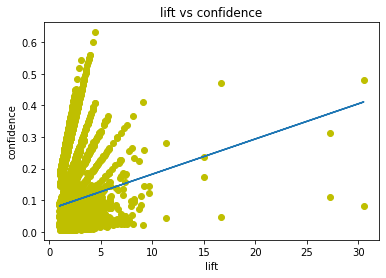

In [47]:
plot_metrics_relationship(apriori_rule_lift, col1='lift', col2='confidence')

In [48]:
apripri_rule = compute_association_rule(apriori_matrix, metric="confidence", min_thresh=0.2)
apripri_rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(100% Whole Wheat Bread),(Banana),0.018668,0.176420,0.004869,0.260845,1.478546,0.001576,1.114218
1,(2% Reduced Fat Milk),(Banana),0.013298,0.176420,0.002845,0.213942,1.212689,0.000499,1.047735
2,(Apple Honeycrisp Organic),(Bag of Organic Bananas),0.017304,0.142376,0.005147,0.297414,2.088930,0.002683,1.220667
3,(Apple Honeycrisp Organic),(Organic Strawberries),0.017304,0.091668,0.003559,0.205665,2.243597,0.001973,1.143513
4,(Asparagus),(Banana),0.026180,0.176420,0.005317,0.203093,1.151193,0.000698,1.033471


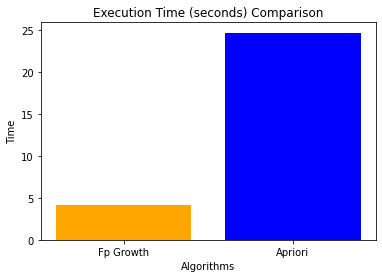

In [60]:
algo1 = ['Fp Growth', fp_growth_exec_time]
algo2 = ['Apriori', apriori_exec_time]

compare_time_exec(algo1, algo2)

In [20]:
from datetime import datetime





In [32]:
startTime = datetime.now()

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_items = apriori(shortbasket, min_support=0.001, use_colnames=True  , low_memory=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.1)



C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [33]:
from pandas import DataFrame
from sqlalchemy import asc



rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

df=pd.DataFrame(rules)

df.head(10).sort_values(by=['antecedent_len','confidence'],ascending=False)
rules[(rules['lift'] >= 1.4) & (rules['confidence'] >= 0.3)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'C:/Users/saidh/Downloads/marketbasketanalysisusingapriori.xlsx', index=False)
startTime1=datetime.now()
tt=(startTime1-startTime).seconds
print('It took ',tt, ' seconds to run')

It took  7  seconds to run


In [35]:
startTime = datetime.now()
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = fpgrowth(shortbasket, min_support=0.001, use_colnames=True)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

df=pd.DataFrame(rules)

df.head(10).sort_values(by=['antecedent_len'],ascending=True)
rules[(rules['lift'] >= 1.4) & (rules['confidence'] >= 0.3)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'C:/Users/saidh/Downloads/marketbasketanalysisusingfpgrowth.xlsx', index=False)

startTime1=datetime.now()
tt1=(startTime1-startTime).seconds
print('It took ',tt1, ' to run')

C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


It took  3  to run
